In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wandb
import os
os.environ["WANDB_SILENT"] = "true"

import gc

import math

from xgboost import XGBRegressor as XGB
from lightgbm import LGBMRegressor as LGB
import lightgbm
from sklearn.metrics import mean_absolute_error as mae
SEED=42

from src.correlations import *
from src.features_train import get_features

from src.styles import *
set_styles()

import warnings
warnings.filterwarnings("ignore")

In [2]:
class SplitKFold:
    def __init__(self, n_splits=3, test_len=3*24*30):
        self.n_splits = n_splits
        self.test_len = test_len
        
    def split(self, X):        
        for fold in range(self.n_splits):
            offset = X['time_id'].max() - (self.n_splits - fold) * self.test_len
            idx_train = X.loc[X['time_id'] < offset].index
            idx_test = X.loc[(X['time_id'] >= offset) & (X['time_id'] < offset + self.test_len)].index            
            yield idx_train, idx_test
            
    def get_n_splits(self, X, y):
        return self.n_splits




def eval(X, Y, splitter, model):
    scores = []
    
    df_oof = pd.DataFrame()
    
    for fold, (idx_train, idx_val) in enumerate(splitter.split(X)):
        X_train = X.loc[idx_train].dropna()
        Y_train = Y.loc[X_train.index]
        Y_val = Y.loc[idx_val].dropna()
        X_val = X.loc[Y_val.index]
        
        model.fit(X_train, Y_train)
        preds = model.predict(X_val)
        score = mae(Y_val, preds)
        scores.append(score)
        
        df = X_val[['time_id', 'is_consumption', 'is_business', 'product_type', 'county']]
        df['preds'] = preds
        df['target'] = Y_val
        df_oof = pd.concat([df_oof, df], axis=0)
        
    return np.array(scores), df_oof


def score_cv(X, Y, factor, splitter, model):
    scores = []
    
    df_oof = pd.DataFrame()
    
    for fold, (idx_train, idx_val) in enumerate(splitter.split(X)):
        X_train = X.loc[idx_train].dropna()
        Y_train = Y.loc[X_train.index]
        Y_val = Y.loc[idx_val].dropna()
        X_val = X.loc[Y_val.index]
        factor_val = factor.loc[Y_val.index]
        
        model.fit(X_train, Y_train)
        preds = model.predict(X_val)
        score = mae(Y_val*factor_val, preds*factor_val)
        scores.append(score)
        
        df = X_val[['time_id', 'is_consumption', 'is_business', 'product_type', 'county']]
        df['preds'] = preds*factor_val
        df['target'] = Y_val*factor_val
        df_oof = pd.concat([df_oof, df], axis=0)
        
    return np.array(scores), df_oof


def score_dif(X, Y, A, splitter, model):
    scores = []
    
    df_oof = pd.DataFrame()
    
    for fold, (idx_train, idx_val) in enumerate(splitter.split(X)):
        X_train = X.loc[idx_train].dropna()
        Y_train = Y.loc[X_train.index]
        Y_val = Y.loc[idx_val].dropna()
        X_val = X.loc[Y_val.index]
        a = A.loc[Y_val.index]
        
        model.fit(X_train, Y_train)
        preds = model.predict(X_val)
        score = mae((Y_val+a)*b, (preds+a)*b)
        scores.append(score)
        
        df = X_val[['time_id', 'is_consumption', 'is_business', 'product_type', 'county']]
        df['preds'] = preds+a
        df['target'] = Y_val+a
        df_oof = pd.concat([df_oof, df], axis=0)
        
    return np.array(scores), df_oof


def print_mae_sep(df_oof):
    for c in [0,1]:
        for b in [0,1]:
            df = df_oof.query(f'(is_consumption=={c}) & (is_business=={b})')    
            print(c, b, end='       ')
            for fold in range(4):
                offset = df['time_id'].max() - (4 - fold) * 3*24*30
                dd = df.loc[(df['time_id'] >= offset) & (df['time_id'] < offset + 3*24*30)]
                print(f"{mae(dd['target'], dd['preds']):.3f}".rjust(10), end='    ')
            print(f"        {mae(df['target'], df['preds']):.3f}")

In [3]:
%%time
df_weather_station_to_county_mapping = pd.read_csv('data/weather_station_to_county_mapping.csv').dropna()
    
df_weather_station_to_county_mapping['lat_lon'] = df_weather_station_to_county_mapping.apply(lambda row: \
                                                     f'{row["latitude"]:.1f}_{row["longitude"]:.1f}', axis=1)
dict_county = df_weather_station_to_county_mapping[['lat_lon', 'county']].set_index('lat_lon').to_dict()['county']

CPU times: total: 0 ns
Wall time: 293 ms


In [4]:
%%time

df_gas_prices = pd.read_csv('data/gas_prices.csv')
df_electricity_prices = pd.read_csv('data/electricity_prices.csv')
df_client = pd.read_csv('data/client.csv')
df_train = pd.read_csv('data/train.csv')
df_forecast_weather = pd.read_csv('data/forecast_weather.csv')
df_historical_weather = pd.read_csv('data/historical_weather.csv')
df = get_features(df_train, df_client, df_gas_prices, df_electricity_prices, df_forecast_weather, df_historical_weather, dict_county)
del df_forecast_weather, df_historical_weather
gc.collect()

CPU times: total: 1min 11s
Wall time: 1min 38s


53

# Dual model

## tuned

In [5]:
%%time
X = df.query('is_consumption==0')
Y = X.pop('target') / X['installed_capacity']

splitter = SplitKFold(n_splits=4)

lgb_best_params_0 = {'device': 'gpu',
 'max_depth': 10,
 'objective': 'mae',
 'reg_alpha': 27.925287981085468,
 'subsample': 0.5976031697826543,
 'reg_lambda': 22.884627910174338,
 'n_estimators': 588,
 'random_state': 42,
 'learning_rate': 0.016017459248525004,
 'colsample_bytree': 0.565707682564599}
model_0 = LGB(verbose=-100, **lgb_best_params_0, num_leaves=2**lgb_best_params_0['max_depth'] - 1)
scores_0, df_oof_dual_0_tuned = score_cv(X, Y, X['installed_capacity'], splitter, model_0)

lgb_best_params_1 = {'device': 'gpu',
 'max_depth': 10,
 'objective': 'mae',
 'reg_alpha': 2.683818422446349,
 'subsample': 0.925323652336999,
 'reg_lambda': 11.286432355402798,
 'n_estimators': 730,
 'random_state': 42,
 'learning_rate': 0.044074000160673456,
 'colsample_bytree': 0.9929981807318676}
X = df.query('is_consumption==1')
Y = X.pop('target') 

splitter = SplitKFold(n_splits=4)
model_1 = LGB(verbose=-100, **lgb_best_params_1, num_leaves=2**lgb_best_params_1['max_depth'] - 1)
scores_1, df_oof_dual_1_tuned = eval(X, Y, splitter, model_1)

df_oof_dual_tuned = pd.concat([df_oof_dual_0_tuned, df_oof_dual_1_tuned], axis=0)
print_mae_sep(df_oof_dual_tuned)

0 0           40.772        16.896         6.375        48.048            27.816
0 1           42.241        14.044         4.858        55.879            29.135
1 0            8.096        18.327        31.504        24.763            20.701
1 1           99.069        89.110        95.912        92.817            94.186
CPU times: total: 43min 41s
Wall time: 25min 30s


## new_target = target - target_lag_48h

In [12]:
%%time

splitter = SplitKFold(n_splits=4)
model = LGB(random_state=SEED, n_estimators=500, max_depth=5, num_leaves=31, objective='mae', device='gpu', verbose=-100)

X = df.query('is_consumption==0')
Y = X.pop('target') - X['target_48']
scores_0, df_oof_dual_0_dif = score_dif(X, Y, X['target_48'], splitter, model)


X = df.query('is_consumption==1')
Y = X.pop('target') - X['target_48']
scores_1, df_oof_dual_1_dif = score_dif(X, Y, X['target_48'], splitter, model)

df_dual_diff = pd.concat([df_oof_dual_0_dif, df_oof_dual_1_dif], axis=0)
print_mae_sep(df_dual_diff) 

0 0           43.630        20.250         8.486        82.804            38.452
0 1           51.167        17.345         5.453        69.986            35.837
1 0            8.372        17.955        32.984        26.912            21.576
1 1           93.143        84.839        95.275        96.603            92.402
CPU times: total: 7min 25s
Wall time: 4min 27s


## mean of predictions

In [13]:
df_oof_dual_mean = 0.5 * (df_oof_dual_tuned + df_dual_diff)
print_mae_sep(df_oof_dual_mean)

0 0           35.935        17.685         6.969        59.565            29.798
0 1           42.909        14.889         4.830        56.806            29.738
1 0            7.690        17.106        29.829        24.131            19.711
1 1           90.988        80.976        86.503        88.891            86.793


# 4-model solution

In [27]:
%%time

df_oofs_tuned = []
splitter = SplitKFold(n_splits=4)

lgb_params = [
    {'device': 'gpu',
 'max_depth': 7,
 'objective': 'mae',
 'reg_alpha': 84.8348443946615,
 'subsample': 0.7457382126409933,
 'reg_lambda': 54.981855156064974,
 'n_estimators': 986,
 'random_state': 42,
 'learning_rate': 0.025958201025540827,
 'colsample_bytree': 0.2316453494439351},
    {'device': 'gpu',
 'max_depth': 9,
 'objective': 'mae',
 'reg_alpha': 0.8552097909171774,
 'subsample': 0.6395685038517376,
 'reg_lambda': 12.912361932527617,
 'n_estimators': 587,
 'random_state': 42,
 'learning_rate': 0.016510018898018324,
 'colsample_bytree': 0.7613937918848874},
    {'device': 'gpu',
 'max_depth': 4,
 'objective': 'mae',
 'reg_alpha': 7.789969529711993,
 'subsample': 0.6788618540001061,
 'reg_lambda': 95.04678210912456,
 'n_estimators': 717,
 'random_state': 42,
 'learning_rate': 0.10662803911937269,
 'colsample_bytree': 0.5440716377164676},
    {'device': 'gpu',
 'max_depth': 7,
 'objective': 'mae',
 'reg_alpha': 32.02008292675173,
 'subsample': 0.9464933926786616,
 'reg_lambda': 13.836202707048916,
 'n_estimators': 758,
 'random_state': 42,
 'learning_rate': 0.03841847402871685,
 'colsample_bytree': 0.9949734593585886 }
]

for c in [0,1]:
    for b in [0,1]:

        X = df.query(f'(is_consumption=={c}) & (is_business=={b})')
        params = lgb_params[c*2+b]
        
        if not ((c==1) and (b==1)):
            Y = X.pop('target') / X['installed_capacity'] 
            scores, df_oof = score_cv(X, Y, X['installed_capacity'], splitter, LGB(verbose=-100, **params, num_leaves=2**params['max_depth'] - 1))
            df_oofs_tuned.append(df_oof)
        else:
            Y = X.pop('target') 
            scores, df_oof = eval(X, Y, splitter, LGB(verbose=-100, **params, num_leaves=2**params['max_depth'] - 1))
            df_oofs_tuned.append(df_oof)

CPU times: total: 31min 38s
Wall time: 14min 3s


In [28]:
df_oof_quad_tuned = pd.concat(df_oofs_tuned, axis=0)
print_mae_sep(df_oof_quad_tuned)

0 0           35.369        16.694         6.652        49.308            26.806
0 1           44.934        14.027         4.956        56.596            30.002
1 0           11.937        15.221        22.132        21.668            17.737
1 1          100.895        86.982       101.835        94.672            96.029


# Visualize predictions

In [33]:
%%time

maes = pd.DataFrame(index=np.arange(138), columns=['c', 'b', 'p', 'county', 'mae'])

nn = 0
for consumption in [0, 1]:
    for business in [0, 1]:
        for product in [0, 1, 2, 3]:
            for county in range(16):
                # last 3 months
                condition = f'(is_consumption == {consumption}) & (is_business == {business}) & (product_type == {product}) & (county == {county}) & (time_id > {15311 - 24*3*30})'
                df = df_oof_quad_tuned.query(condition)
                if df.shape[0] > 0:
                    maes.loc[nn] = [consumption, business, product, county, mae(df['target'], df['preds'])]

                    nn+=1

CPU times: total: 4.31 s
Wall time: 5.11 s


In [73]:
maes.sort_values('mae').head(10)

,c,b,p,county,mae
16,0,0,2,11,1.087512
15,0,0,2,7,1.302972
85,1,0,2,11,1.441439
84,1,0,2,7,1.78411
49,0,1,2,0,3.068612
38,0,1,1,2,3.152932
80,1,0,1,13,3.37026
70,1,0,1,1,3.947036
83,1,0,2,0,4.394939
11,0,0,1,13,5.244926


In [75]:
maes.sort_values('mae').tail(10)

,c,b,p,county,mae
127,1,1,3,5,161.741096
64,0,1,3,11,172.121701
86,1,0,3,0,179.826385
27,0,0,3,11,195.367529
136,1,1,3,14,224.965348
53,0,1,3,0,296.820644
17,0,0,3,0,332.157682
66,0,1,3,13,353.141324
133,1,1,3,11,495.46265
122,1,1,3,0,775.804745


In [61]:
def show_target(df_train, is_cons, is_bus, prod, county, x0, x1):
    df = df_train.query(f'(is_consumption == {is_cons}) & (is_business == {is_bus}) & (product_type == {prod}) & (county == {county})') \
                 .reset_index(drop=True)[x0:x1]

    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

    m = mae(df['target'], df['preds'])

    sns.lineplot(x=df.index / 24 + 638 - 360, y=df['target'], ax=ax, color=PALETTE[0], label='target')
    sns.lineplot(x=df.index / 24 + 638 - 360, y=df['preds'], ax=ax, color=PALETTE[1], label='prediction')
    ax.grid(True)
    ax.set_title(f'is_consumption {is_cons}, is_business {is_bus}, product_type {prod}, county {county}   |   MAE {m:.2f}', fontsize=10)
    ax.set_xlabel('data_block_id')

    plt.tight_layout()
    # plt.savefig(f'prediction_OOF_{is_cons}_{is_bus}_{prod}_{county}.png')
    plt.show()

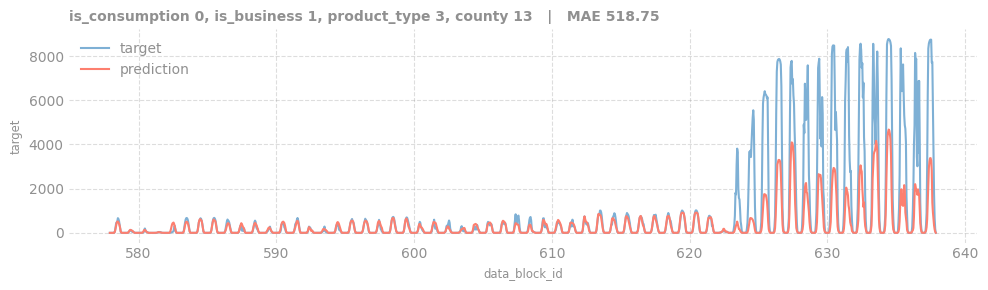

In [68]:
show_target(df_oof_quad_tuned, 0,1,3,13, -24*60,None)

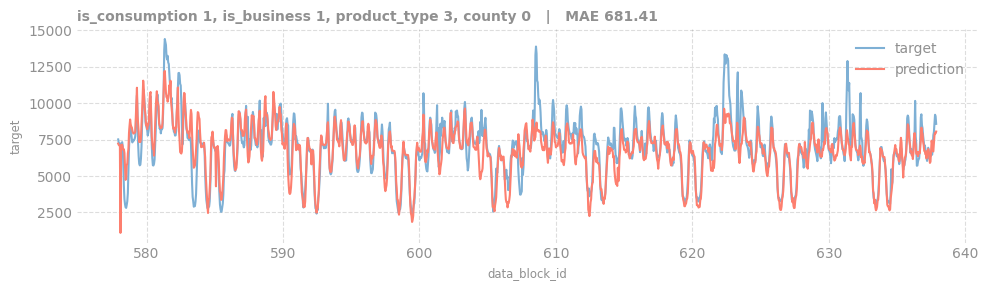

In [67]:
show_target(df_oof_quad_tuned, 1,1,3,0, -24*60,None)


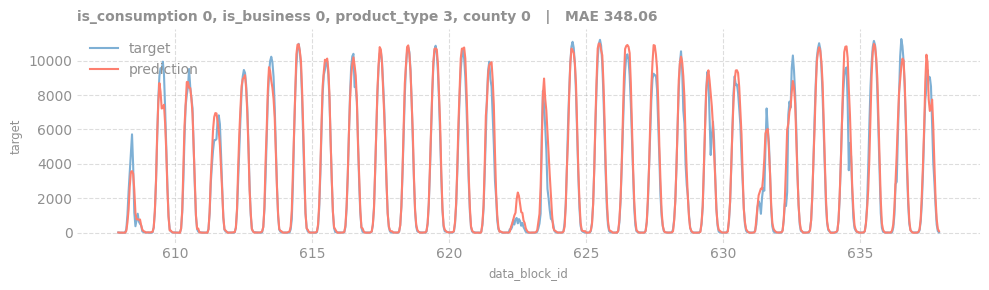

In [64]:
show_target(df_oof_quad_tuned, 0,0,3,0, -24*30,None)


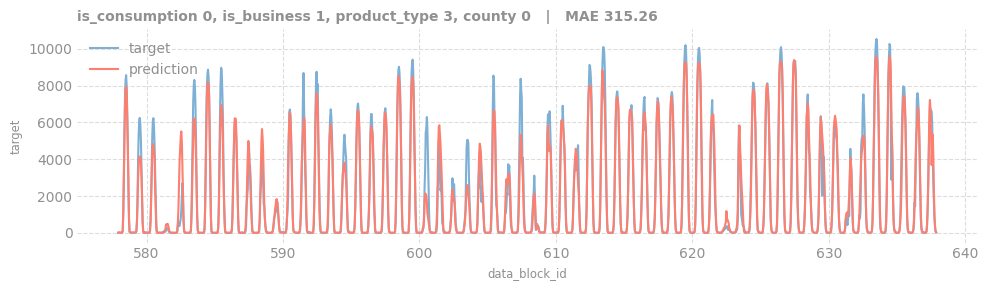

In [69]:
show_target(df_oof_quad_tuned, 0,1,3,0, -24*60,None)


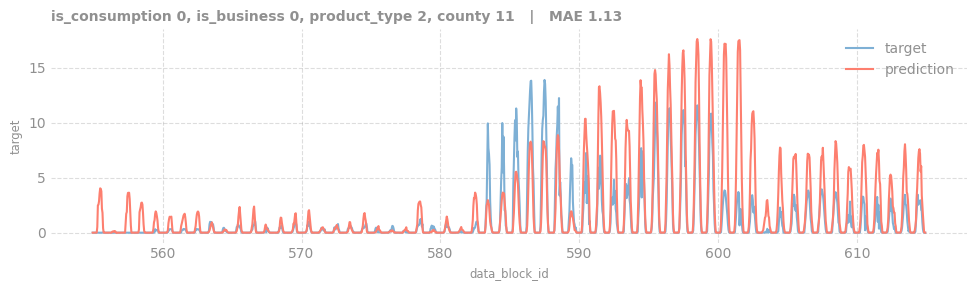

In [70]:
show_target(df_oof_quad_tuned, 0,0,2,11, -24*60,None)


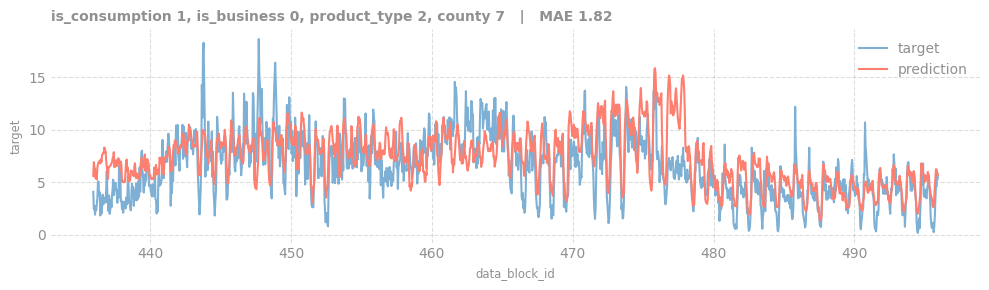

In [71]:
show_target(df_oof_quad_tuned, 1,0,2,7, -24*60,None)

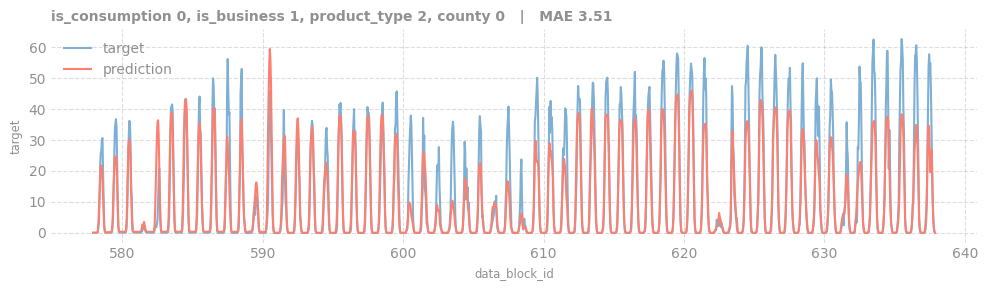

In [72]:
show_target(df_oof_quad_tuned, 0,1,2,0, -24*60,None)


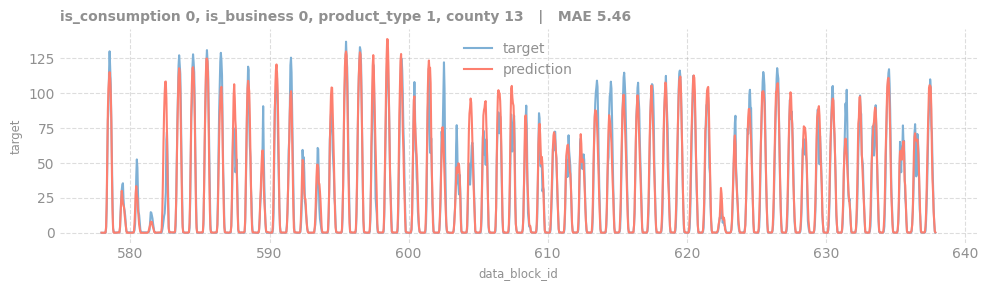

In [74]:
show_target(df_oof_quad_tuned, 0,0,1,13, -24*60,None)